In [2]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer



from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


In [3]:
data = pd.read_csv("mbti_1.csv")
data.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
data.describe(include='O')

,type,posts
count,8675,8675
unique,16,8675
top,INFP,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq,1832,1


In [5]:
data.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

In [6]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    8675 non-null   object
 1   posts   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [7]:
types = np.unique(np.array(df['type']))
types

array(['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP', 'ESTJ', 'ESTP',
       'INFJ', 'INFP', 'INTJ', 'INTP', 'ISFJ', 'ISFP', 'ISTJ', 'ISTP'],
      dtype=object)

In [8]:
total = df.groupby(['type']).count()
total

,posts
type,
ENFJ,190
ENFP,675
ENTJ,231
ENTP,685
ESFJ,42
ESFP,48
ESTJ,39
ESTP,89
INFJ,1470


In [9]:
df.posts[0]

"'http://www.youtube.com/watch?v=qsXHcwe3krw|||http://41.media.tumblr.com/tumblr_lfouy03PMA1qa1rooo1_500.jpg|||enfp and intj moments  https://www.youtube.com/watch?v=iz7lE1g4XM4  sportscenter not top ten plays  https://www.youtube.com/watch?v=uCdfze1etec  pranks|||What has been the most life-changing experience in your life?|||http://www.youtube.com/watch?v=vXZeYwwRDw8   http://www.youtube.com/watch?v=u8ejam5DP3E  On repeat for most of today.|||May the PerC Experience immerse you.|||The last thing my INFJ friend posted on his facebook before committing suicide the next day. Rest in peace~   http://vimeo.com/22842206|||Hello ENFJ7. Sorry to hear of your distress. It's only natural for a relationship to not be perfection all the time in every moment of existence. Try to figure the hard times as times of growth, as...|||84389  84390  http://wallpaperpassion.com/upload/23700/friendship-boy-and-girl-wallpaper.jpg  http://assets.dornob.com/wp-content/uploads/2010/04/round-home-design.jpg ...

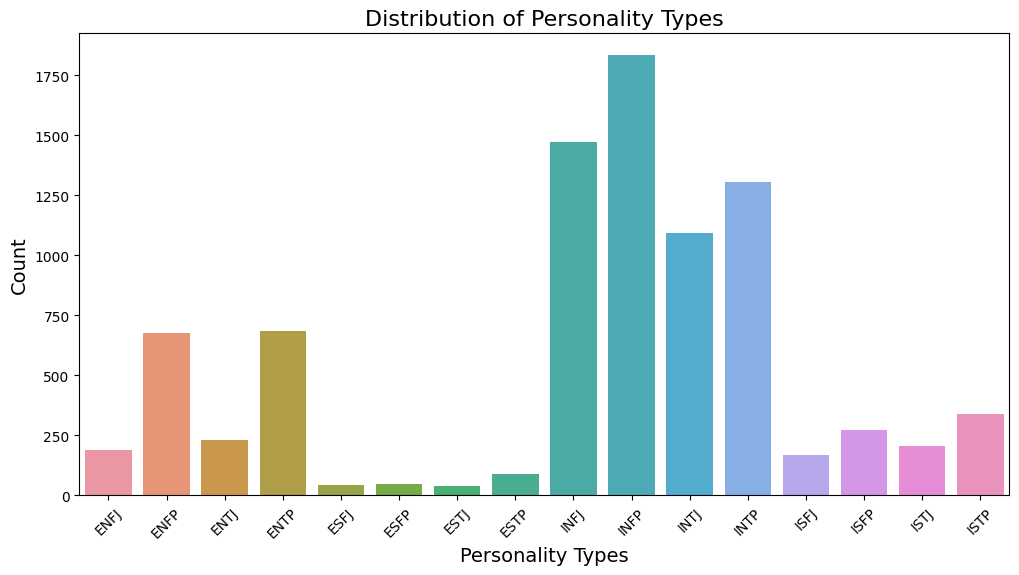

In [10]:

plt.figure(figsize=(12, 6))
sns.barplot(x=total.index, y=total['posts'])
plt.xlabel('Personality Types', size=14)
plt.ylabel('Count', size=14)
plt.title('Distribution of Personality Types', size=16)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

output_folder = 'static'
output_path = os.path.join(output_folder, 'Distribution_Types.png')
plt.savefig(output_path)
plt.show()


In [11]:
#Pie Chart

import os
import plotly.express as px


fig = px.pie(total, values='posts', names=total.index, title='Distribution of Personality Types',
             color_discrete_sequence=px.colors.qualitative.Pastel, hole=0.4,
             hover_data=['posts'], custom_data=['posts'])

fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0), 
    font=dict(size=12),
)

output_path = os.path.join(output_folder, 'personalities.html')

fig.write_html(output_path, include_plotlyjs='cdn')


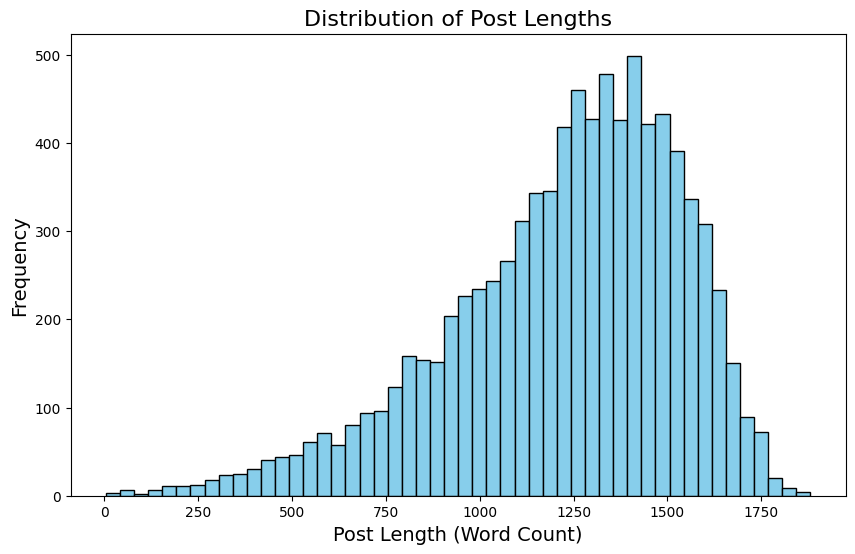

In [12]:

df['post_length'] = df['posts'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
plt.hist(df['post_length'], bins=50, color='skyblue', edgecolor='black')  # Adjust the number of bins as needed
plt.xlabel('Post Length (Word Count)', size=14)
plt.ylabel('Frequency', size=14)
plt.title('Distribution of Post Lengths', size=16)

output_path = os.path.join(output_folder, 'post_length.png')
plt.savefig(output_path)
plt.show()

In [13]:
from collections import Counter
words = list(df["posts"].apply(lambda x: x.split()))
words = [x for y in words for x in y]
Counter(words).most_common(50)

[('I', 387957),
 ('to', 290168),
 ('the', 270699),
 ('a', 230918),
 ('and', 219498),
 ('of', 177853),
 ('is', 128804),
 ('you', 128750),
 ('that', 127221),
 ('in', 117263),
 ('my', 104561),
 ('it', 93101),
 ('for', 83057),
 ('have', 79784),
 ('with', 77131),
 ('but', 74729),
 ('be', 69317),
 ('are', 65034),
 ('like', 61390),
 ('not', 59496),
 ('an', 59020),
 ("I'm", 57339),
 ('on', 57062),
 ('was', 56146),
 ('me', 55488),
 ('as', 53310),
 ('this', 52601),
 ('just', 48292),
 ('about', 46305),
 ('think', 46229),
 ('or', 45724),
 ("don't", 44821),
 ('so', 42935),
 ('your', 40918),
 ('do', 40867),
 ('what', 37746),
 ('at', 37566),
 ('can', 37535),
 ('if', 37042),
 ('people', 35546),
 ('when', 34389),
 ('would', 32605),
 ('really', 31369),
 ('all', 31344),
 ('more', 31188),
 ('know', 31130),
 ('they', 29386),
 ('get', 28948),
 ('because', 27438),
 ('am', 27109)]

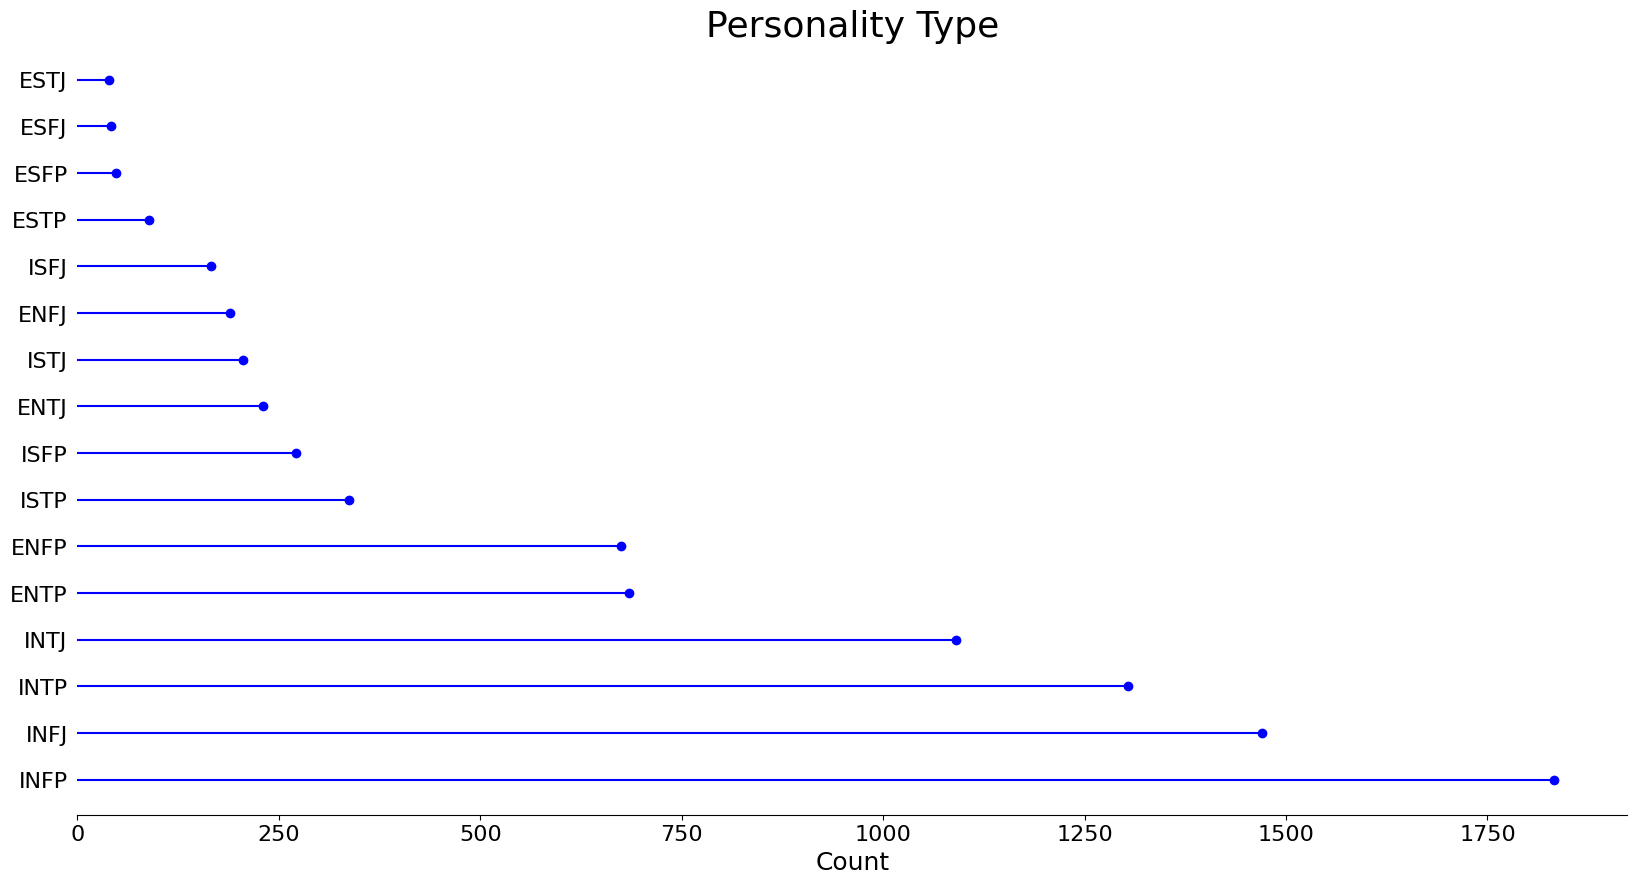

In [14]:

count=dict(df['type'].value_counts())
plt.figure(figsize=(20,10))
plt.hlines(y=count.keys(), xmin=0, xmax=count.values(), color='blue')
plt.plot(count.values(),count.keys(), 'o', color='blue')
plt.title('Personality Type', fontsize=26)
plt.xlabel('Count', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, None)
plt.tick_params(left=False)
sns.despine(left=True)


output_path = os.path.join(output_folder, 'length.png')
plt.savefig(output_path)
plt.show()

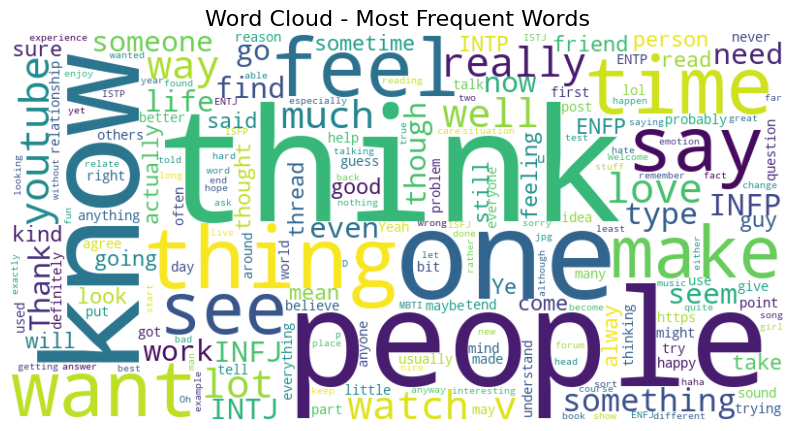

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt


text = ' '.join(df['posts'])  


wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=200).generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  
plt.title('Word Cloud - Most Frequent Words', size=16)


output_path = os.path.join(output_folder, 'Word_Cloud.png')
plt.savefig(output_path)
plt.show()

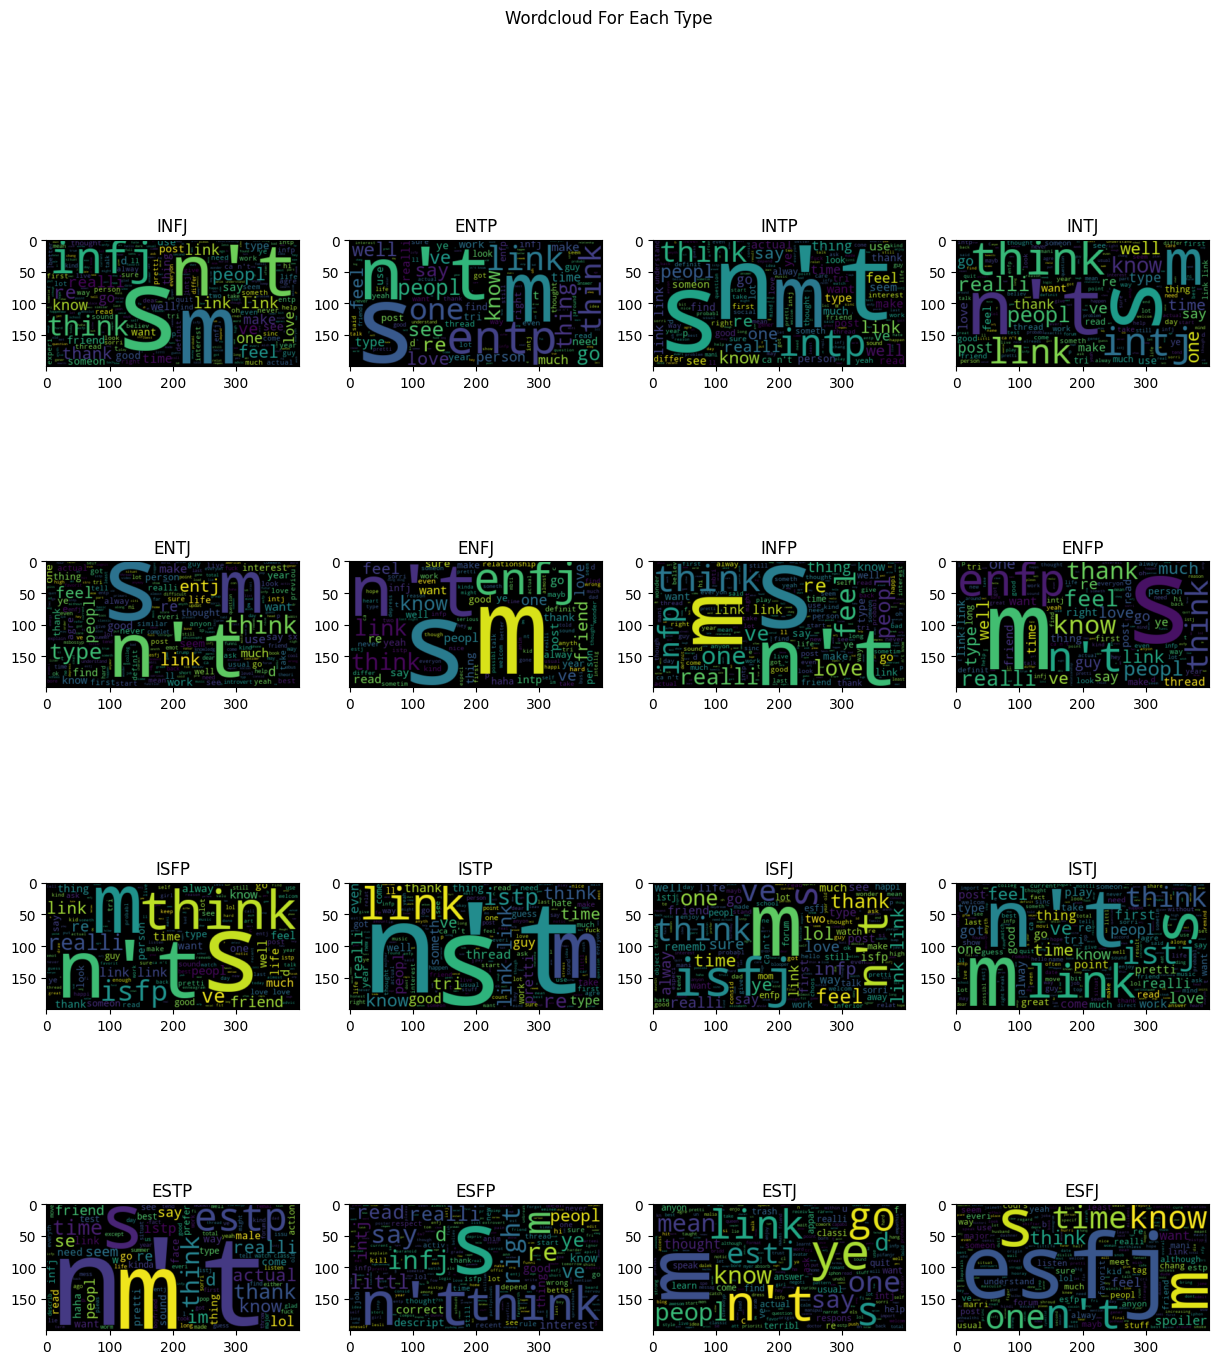

In [31]:
fig, ax = plt.subplots(len(df['type'].unique()), figsize=(15,len(df['type'].unique())))
plt.suptitle("Wordcloud For Each Type")
k = 0
for i in df['type'].unique():
    df_4 = df[df['type'] == i]
    wordcloud = WordCloud(max_words=1628,relative_scaling=1,normalize_plurals=False).generate(df_4['posts'].to_string())
    plt.subplot(4,4,k+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(i)
    
    ax[k].axis("off")
    k+=1

output_path = os.path.join(output_folder, '16wordcloud.png')
plt.savefig(output_path)

In [17]:
text = df.iloc[0:3].copy()
text

,type,posts,post_length
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,556
1,ENTP,'I'm finding the lack of me in these posts ver...,1170
2,INTP,'Good one _____ https://www.youtube.com/wat...,836


In [18]:
def strip(text):
    return text.strip("'").split('|||')

In [19]:
df['posts'] = df['posts'].str.lower()
df

,type,posts,post_length
0,INFJ,'http://www.youtube.com/watch?v=qsxhcwe3krw|||...,556
1,ENTP,'i'm finding the lack of me in these posts ver...,1170
2,INTP,'good one _____ https://www.youtube.com/wat...,836
3,INTJ,"'dear intp, i enjoyed our conversation the o...",1064
4,ENTJ,'you're fired.|||that's another silly misconce...,967
...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edhb_h908||...,796
8671,ENFP,'so...if this thread already exists someplace ...,1309
8672,INTP,'so many questions when i do these things. i ...,948
8673,INFP,'i am very conflicted right now when it comes ...,1705


In [20]:
df['posts'] = df['posts'].apply(strip)
df

,type,posts,post_length
0,INFJ,"[http://www.youtube.com/watch?v=qsxhcwe3krw, h...",556
1,ENTP,[i'm finding the lack of me in these posts ver...,1170
2,INTP,[good one _____ https://www.youtube.com/wat...,836
3,INTJ,"[dear intp, i enjoyed our conversation the o...",1064
4,ENTJ,"[you're fired., that's another silly misconcep...",967
...,...,...,...
8670,ISFP,"[https://www.youtube.com/watch?v=t8edhb_h908, ...",796
8671,ENFP,[so...if this thread already exists someplace ...,1309
8672,INTP,[so many questions when i do these things. i ...,948
8673,INFP,[i am very conflicted right now when it comes ...,1705


In [21]:
def join_strings(string_list):
    return ' '.join(string_list)

df['posts'] = df['posts'].apply(join_strings)
df

,type,posts,post_length
0,INFJ,http://www.youtube.com/watch?v=qsxhcwe3krw htt...,556
1,ENTP,i'm finding the lack of me in these posts very...,1170
2,INTP,good one _____ https://www.youtube.com/watc...,836
3,INTJ,"dear intp, i enjoyed our conversation the ot...",1064
4,ENTJ,you're fired. that's another silly misconcepti...,967
...,...,...,...
8670,ISFP,https://www.youtube.com/watch?v=t8edhb_h908 ix...,796
8671,ENFP,so...if this thread already exists someplace e...,1309
8672,INTP,so many questions when i do these things. i w...,948
8673,INFP,i am very conflicted right now when it comes t...,1705


In [22]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\altie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import re

def preprocess_text(text):
 
    text = re.sub(r'(http|https|www)\S+', 'link', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    filtered=[]
    for word in tokens:
        if word.lower() not in stop_words:
            filtered.append(word)
  
    
    stemmer = PorterStemmer()
    stemmed=[]
    for word in filtered:
        stemmed.append(stemmer.stem(word))

    processed_text = ' '.join(stemmed)
    
    return processed_text

In [24]:
df['posts'] = df['posts'].apply(preprocess_text)
df

,type,posts,post_length
0,INFJ,link link enfp intj moment link sportscent top...,556
1,ENTP,'m find lack post alarm . sex bore 's posit of...,1170
2,INTP,"good one _____ link cours , say know ; 's bles...",836
3,INTJ,"dear intp , enjoy convers day . esoter gab nat...",1064
4,ENTJ,'re fire . 's anoth silli misconcept . approac...,967
...,...,...,...
8670,ISFP,link ixfp alway think cat fi dom reason . link...,796
8671,ENFP,... thread alreadi exist someplac els ( : link...,1309
8672,INTP,mani question thing . would take purpl pill . ...,948
8673,INFP,conflict right come want children . honestli m...,1705


In [25]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['posts'])

feature_names = tfidf_vectorizer.get_feature_names_out() 

In [26]:
features_df = tfidf_matrix.toarray()
features_df

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.04544078, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [27]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()
new_df = pd.DataFrame()
new_df['type'] = enc.fit_transform(df['type'])

target = new_df['type'] 
target

0        8
1        3
2       11
3       10
4        2
        ..
8670    13
8671     1
8672    11
8673     9
8674     9
Name: type, Length: 8675, dtype: int32

In [28]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.33, stratify=target, random_state=42)
print ((X_train.shape),(y_train.shape),(X_test.shape),(y_test.shape))

(5812, 85509) (5812,) (2863, 85509) (2863,)


In [29]:

random_forest = RandomForestClassifier(n_estimators=100, random_state = 1)
random_forest.fit(X_train, y_train)

Y_pred = random_forest.predict(X_test)
predictions = [round(value) for value in Y_pred]

accuracy = accuracy_score(y_test, predictions)

print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 38.04%


In [30]:
import joblib

joblib.dump(random_forest, 'random_forest_model.pkl')

['random_forest_model.pkl']